In [1]:
%%bash

pip install -q kaggle
mkdir -p ~/.kaggle
cp drive/MyDrive/kaggle.json ~/.kaggle/
chmod 600 /root/.kaggle/kaggle.json
kaggle datasets download -d arunrk7/surface-crack-detection
unzip -qq surface-crack-detection.zip

100%|██████████| 233M/233M [00:01<00:00, 202MB/s]


In [2]:
%%bash

mkdir surface-crack-detection
mv Negative surface-crack-detection
mv Positive surface-crack-detection 

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.11.0'

In [3]:
data_dir = pathlib.Path("surface-crack-detection")
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

40000

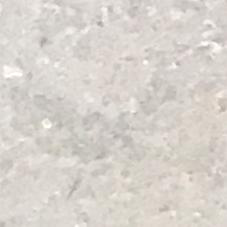

In [4]:
positive = list(data_dir.glob("Negative/*"))
PIL.Image.open(str(positive[0]))

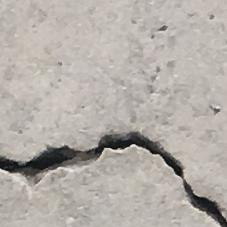

In [5]:
negative = list(data_dir.glob("Positive/*"))
PIL.Image.open(str(negative[0]))

In [6]:
img_height = 227
img_width = 227
batch_size = 32

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=437,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=437,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


In [8]:
class_names = train_ds.class_names
class_names

['Negative', 'Positive']

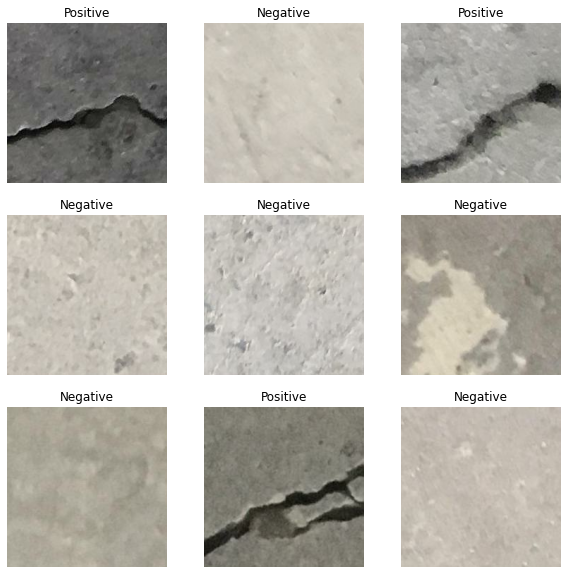

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 227, 227, 3)
(32,)


In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
np.min(first_image), np.max(first_image)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(0.14509805, 1.0)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [14]:
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(227, 227, 3))
base_model.trainable = False

In [15]:
inputs = tf.keras.layers.Input(shape=(227, 227, 3))
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [16]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 27,560,769
Trainable params: 12,846,081
Non-tra

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
 237/1000 [======>.......................] - ETA: 1:51 - loss: 0.3988 - accuracy: 0.9796